##Sympy
---
Sympy is a python libraries prrmarily designed for symbolic calculation (and other things). Let us show that how we can use it to simply our calculation for logistic functions. 

In [1]:
!pip install sympy

In [2]:
from sympy import *
init_printing(use_unicode=True)

In [3]:
x = symbols('x')

In [4]:
def sigma(x):
    return 1/(1 + exp(-x))

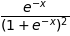

In [5]:
diff(sigma(x), x)

In [6]:
def log_lik(t):
    return log(sigma(t))
def log_lik_minus(t):
    return log(1-sigma(t))

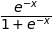

In [7]:
diff(log_lik(x),x)

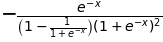

In [8]:
diff(log_lik_minus(x), x)

The results above are ugly. Let us try to simplify it using `simplify` function.

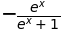

In [9]:
simplify(diff(log_lik_minus(x), x))

Let us use sympy to simplify certain notations. Pay attention that we have used $m$ to replace the $x_i^t\beta$ part in the lecture notes. 

In [10]:
 m, y = symbols('m y')
 def my_expression(m, y):
     return y * (exp(-m)/(1+exp(-m))) - (1-y)*(exp(m)/(1+exp(m)))

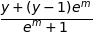

In [11]:
simplify(my_expression(m, y))

## Jax time

Now let us try to use Jax to derive a useful version of optimize routine. 

In [244]:
import jax 
from jax import lax
from jax import random
import jax.numpy as jnp

In [274]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

In [280]:
key = random.PRNGKey(0)
x_key, beta_key, beta_test_key = random.split(key,3)
x = random.normal(x_key, (10000, 10))
beta = random.normal(beta_key, (10,))*2
beta_test = random.normal(beta_test_key, (10,))
y = (sigmoid(x.dot(beta))>=0.5).astype(jnp.float32)


In [281]:
y.sum() # Check whether the results are reasonable

DeviceArray(5017., dtype=float32)

In [284]:
def predict(beta, x):
    return sigmoid(x.dot(beta))

def loss(beta):
    preds = predict(beta,x)
    label_probs = preds * y + (1 - preds) * (1 - y)
    return -jnp.sum(jnp.log(label_probs))/10000.00 

In [285]:
jax.grad(loss)(beta)

DeviceArray([ 0.00455573,  0.01565121, -0.00860528, -0.00485264,
              0.00207953, -0.00256935,  0.00626604, -0.00537516,
              0.0021444 , -0.00108901], dtype=float32)

In [286]:
jax.grad(loss)(beta_test)

DeviceArray([ 0.24341547,  0.29687792, -0.02719581, -0.13187408,
             -0.05313727, -0.11881256,  0.1569478 ,  0.10492601,
             -0.05401436, -0.03668952], dtype=float32)

# Question: What can We See from This Implementation?

The derivatives should be close to $0$. Because we are evaluating it at the true function. It should never be equal to $0$ because we generally never have unlimited sample for that, however, it should not be too huge as well. 

Also, it should in general be different from, say, a randomly initialized beta. 

Now let us try to make our own implementation of the grad function. It should be close to what autograd gives us. 

What we have derived is that the gradient is \begin{align*}
-\sum_i (y_i - \sigma(x_i^t\beta) )x_i 
\end{align*}

This isn't the most convenint form for implementation, thanks to the pesky summation. 

# Question: How Can we Simplify the Above Expression?

In [291]:
# Why this makes sense?
def custom_grad(beta):
    residual = y - predict(beta, x)
    return jnp.transpose(x).dot(-residual)/10000.00

In [292]:
custom_grad(beta)

DeviceArray([ 0.00455572,  0.01565119, -0.00860529, -0.00485265,
              0.00207953, -0.00256935,  0.00626603, -0.00537516,
              0.00214439, -0.00108901], dtype=float32)

In [293]:
custom_grad(beta_test)

DeviceArray([ 0.24341445,  0.29687792, -0.02719574, -0.13187398,
             -0.0531371 , -0.1188125 ,  0.15694797,  0.10492576,
             -0.05401447, -0.03668943], dtype=float32)